In [50]:
import graphviz
import numpy.typing as npt
import numpy as np
import pandas as pd
import copy
import matplotlib.pyplot as plt

from typing import Any, Dict, Optional
from abc import abstractmethod, ABC
from sklearn.base import BaseEstimator
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor, plot_tree

from IPython.display import display

In [2]:
class AbstractTree(BaseEstimator, ABC):

    def __init__(self, max_depth: int = 5, min_samples_leaf: Optional[int] = None) -> None:
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.tree = None

    @abstractmethod
    def fit(self, X_train: np.ndarray, y_train: np.ndarray) -> None:
        self.tree = self._build_tree(X_train, y_train, depth=0)

    @abstractmethod
    def predict(self, X_test: np.ndarray) -> np.ndarray:
        if not self.tree:
            raise ValueError(f'The tree has not been fitted. Call `fit()` method first.')
        
        return self._predict_tree(X_test, self.tree)

    @abstractmethod
    def _build_tree(self, X_train: np.ndarray, y_train: np.ndarray, depth: int) -> None:
        raise NotImplementedError

    @abstractmethod
    def _predict_tree(self, X: np.ndarray, tree: Any) -> np.ndarray:
        return NotImplementedError

In [3]:
class Criterion:

    def __init__(self, criterion_name: str) -> None:
        self.criterion_name = criterion_name
        self.__impurity_measurements = {
            'entropy': self._calculate_entropy,
            'gini': self._calculate_gini_index,
            'rss': self._calculate_rss,
            'mse': self._calculate_mse
        }
        
    def _calculate_entropy(self, y: np.ndarray) -> np.ndarray[Any]:
        y = np.asarray(y).flatten()
        class_counts = np.bincount(y)
        probabilities = class_counts  / len(y)
        probabilities = probabilities[probabilities > 0]
        eps = 1e-15
        entropy = -np.sum(probabilities * np.log2(probabilities + eps))
        return entropy
        
    def _calculate_gini_index(self, y: np.ndarray) -> np.ndarray[Any]:
        y = np.asarray(y).flatten()
        class_counts = np.bincount(y)
        probabilities = class_counts / len(y)
        gini_index = 1 - np.sum(np.square(probabilities))
        return gini_index

    def _calculate_rss(self, y_train: np.ndarray, y_pred: np.ndarray) -> np.ndarray:
        return np.sum(np.square(y_train - y_pred))

    def _calculate_mse(self, y_train: np.ndarray, y_pred: np.ndarray) -> np.ndarray:
        return np.sum(np.square(y_train - y_pred)) / len(y_train)

    def calculate_impurity(self, y, y_pred=None):
        impurity_calculator = self.__impurity_measurements.get(self.criterion_name)
        if not impurity_calculator:
            raise ValueError(f'Invalid criterion name: "{self.criterion_name}".')
        if self.criterion_name.lower() in ('rss', 'mse'):
            return impurity_calculator(y, y_pred)
        return impurity_calculator(y)
        


In [188]:
class RegressionTree(AbstractTree):

    def __init__(self, max_depth: int = 5, min_samples_leaf: Optional[int] = None, criterion='rss', ccp_alpha = 0.0) -> None:
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        if criterion not in ('rss', 'mse'):
            raise ValueError(f'Inaproperiate impurity measure for regression problem.')
        self.criterion = Criterion(criterion)
        self.ccp_alpha = ccp_alpha
        self.num_leaves = 0
        
    def fit(self, X_train: np.ndarray, y_train: np.ndarray) -> None:
        super().fit(X_train, y_train)
        if self.ccp_alpha > 0.0:
            self._prune_tree(self.tree, X_train, y_train)

    def predict(self, X_test: np.ndarray) -> np.ndarray:
        return super().predict(X_test)
        
    def _build_tree(self, X_train: np.ndarray, y_train: np.ndarray, depth: int) -> Dict[str, float]:

        if self.max_depth == depth or len(np.unique(y_train)) == 1 or (self.min_samples_leaf and len(y_train) <= self.min_samples_leaf):
            self.num_leaves += 1
            return {
                'value': np.mean(y_train),
                'samples': len(y_train),
                'impurity': self.criterion.calculate_impurity(y_train, np.mean(y_train))
            }

        best_split = self._find_best_split(X_train, y_train)
        if not best_split:
            return {
                'value': np.mean(y_train),
                'samples': len(y_train),
                'impurity': self.criterion.calculate_impurity(y_train, np.mean(y_train))
            }

        node = {
            'feature_index': best_split['feature_index'],
            'threshold': best_split['threshold'],
            'impurity': best_split['impurity'],
            'value': None,
            'left': None,
            'right': None,
            'samples': len(y_train)
        }

        left_mask = X_train[:, best_split['feature_index']] < best_split['threshold']
        right_mask = ~left_mask

        node['left'] = self._build_tree(X_train[left_mask, :], y_train[left_mask], depth + 1)
        node['right'] = self._build_tree(X_train[right_mask, :], y_train[right_mask], depth + 1)

        return node

    def _find_best_split(self, X_train: np.ndarray, y_train: np.ndarray) -> Optional[Dict[str, Any]]:
        best_split = None
        best_impurity = float('inf')
    
        for feature_index in range(X_train.shape[1]):
            # https://datascience.stackexchange.com/questions/24339/how-is-a-splitting-point-chosen-for-continuous-variables-in-decision-trees
            sorted_thresholds = np.sort(X_train[:, feature_index])
            midpoint_thresholds = (sorted_thresholds[:-1] + sorted_thresholds[1:]) / 2
            for threshold in midpoint_thresholds:
                left_mask = X_train[:, feature_index] < threshold
                right_mask = ~left_mask
    
                y_left = y_train[left_mask]
                y_right = y_train[right_mask]
    
                if len(y_left) == 0 or len(y_right) == 0:
                    continue
    
                y_pred_left = np.mean(y_left)
                y_pred_right = np.mean(y_right)
    
                impurity_left = self.criterion.calculate_impurity(y_left, y_pred_left)
                impurity_right = self.criterion.calculate_impurity(y_right, y_pred_right)
    
                total_impurity = impurity_left + impurity_right    
    
                if total_impurity < best_impurity:
                    best_impurity = total_impurity
                    best_split = {
                        'feature_index': feature_index,
                        'threshold': threshold,
                        'impurity': total_impurity,
                        'left': y_pred_left,
                        'right': y_pred_right
                    }
    
        return best_split

    def _predict_tree(self, X_test: np.ndarray, node: Any) -> np.ndarray:
        if node['value'] is not None:
            return np.full(X_test.shape[0], node['value'])
    
        left_mask = X_test[:, node['feature_index']] < node['threshold']
        right_mask = ~left_mask
    
        predictions = np.empty(X_test.shape[0])
        predictions[left_mask] = self._predict_tree(X_test[left_mask, :], node['left'])
        predictions[right_mask] = self._predict_tree(X_test[right_mask, :], node['right'])
    
        return predictions

    def _prune_tree(self, node: Dict[str, Any], X_train: np.ndarray, y_train: np.ndarray, alpha=None) -> float:
        alpha = self.ccp_alpha if alpha is None else alpha
    
        if node.get('left') is None and node.get('right') is None:  # if the node is a leaf
            return self.criterion.calculate_impurity(y_train, np.mean(y_train)) + alpha
    
        left_mask = X_train[:, node['feature_index']] < node['threshold']
        if node.get('left') is not None:
            left_cost = self._prune_tree(node['left'], X_train[left_mask, :], y_train[left_mask], alpha)
        else:
            left_cost = 0
    
        right_mask = ~left_mask
        if node.get('right') is not None:
            right_cost = self._prune_tree(node['right'], X_train[right_mask, :], y_train[right_mask], alpha)
        else:
            right_cost = 0
    
        total_cost_complexity = left_cost + right_cost
        leaf_cost = self.criterion.calculate_impurity(y_train, np.mean(y_train)) + alpha
    
        if total_cost_complexity > leaf_cost:
            node['left'] = None
            node['right'] = None
            node['value'] = np.mean(y_train)
            return leaf_cost
    
        return total_cost_complexity

    def get_num_leaves(self) -> int:
        return self.num_leaves
    
    def get_subtree(self, alpha: float) -> Dict[str, Any]:
        pruned_tree = copy.deepcopy(self.tree)
        self._prune_tree(pruned_tree, X_train, y_train, alpha=alpha)
        return pruned_tree

#### Entropy measure

Entropy can be expresed as the amount of the disorder among the data. It tells us about the impurity of the node, and the values are in $[0, 1]$. 

Entropy can be written as:
$$
\text{Entropy} = -\sum_{i=1}^{c}p_i\cdot log_2(p_i)
$$

Where:
- $c$ is the number of class,
- $p_i$ is the probability of the $i$th class.

In [5]:
np.random.seed(42)
data_size = 100
criterion_instance = Criterion('entropy')
class_distribution = np.linspace(0.01, 0.99, data_size)
entropies = [criterion_instance.calculate_impurity(np.random.choice([0, 1], p=[p, 1-p], size=100)) for p in class_distribution]

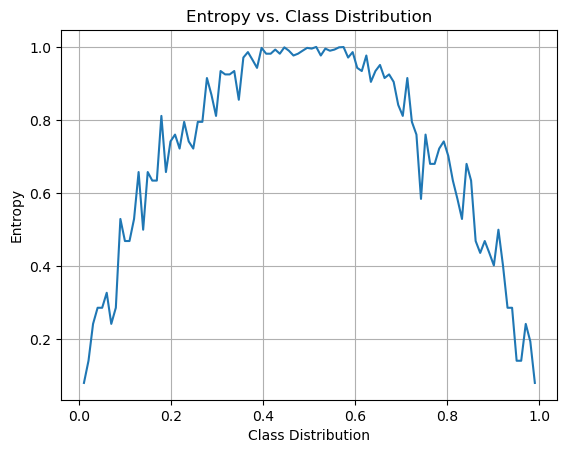

In [6]:
plt.plot(class_distribution, entropies)
plt.title('Entropy vs. Class Distribution')
plt.xlabel('Class Distribution')
plt.ylabel('Entropy')
plt.grid('on')
plt.show()

In [227]:
def build_graph(tree, dot, parent_node=None, parent_edge_label=None):
    if tree is None:
        return

    if 'feature_index' in tree:
        node_name = str(id(tree))
        feature_index = tree['feature_index']
        threshold = tree['threshold']
        impurity = tree['impurity']
        num_samples = tree['samples']

        label = f"Feature Index: X[{feature_index}] <= {threshold:.4f}\nImpurity:{impurity:.4f}\nSamples: {num_samples}"
        dot.node(node_name, label=label)
        
        if parent_node is not None and parent_edge_label is not None:
            dot.edge(parent_node, node_name, label=parent_edge_label)
        
        build_graph(tree['left'], dot, node_name, "left")
        build_graph(tree['right'], dot, node_name, "right")
    else:
        node_name = str(id(tree))
        value = tree['value']
        num_samples = tree['samples']
        impurity = tree['impurity']
        
        label = f"Impurity: {impurity:.4f}\nValue: {value:.4f}\nSamples: {num_samples}"
        dot.node(node_name, label=label)
        
        if parent_node is not None and parent_edge_label is not None:
            dot.edge(parent_node, node_name, label=parent_edge_label)


### Generating data

In [137]:
X, y = make_regression(n_samples=100, n_features=1, noise=20, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (80, 1)
X_test shape: (20, 1)
y_train shape: (80,)
y_test shape: (20,)


In [138]:
reg_tree = RegressionTree(max_depth=3, criterion='rss')
reg_tree.fit(X_train, y_train)

In [139]:
dot = graphviz.Digraph()
build_graph(reg_tree.tree, dot)

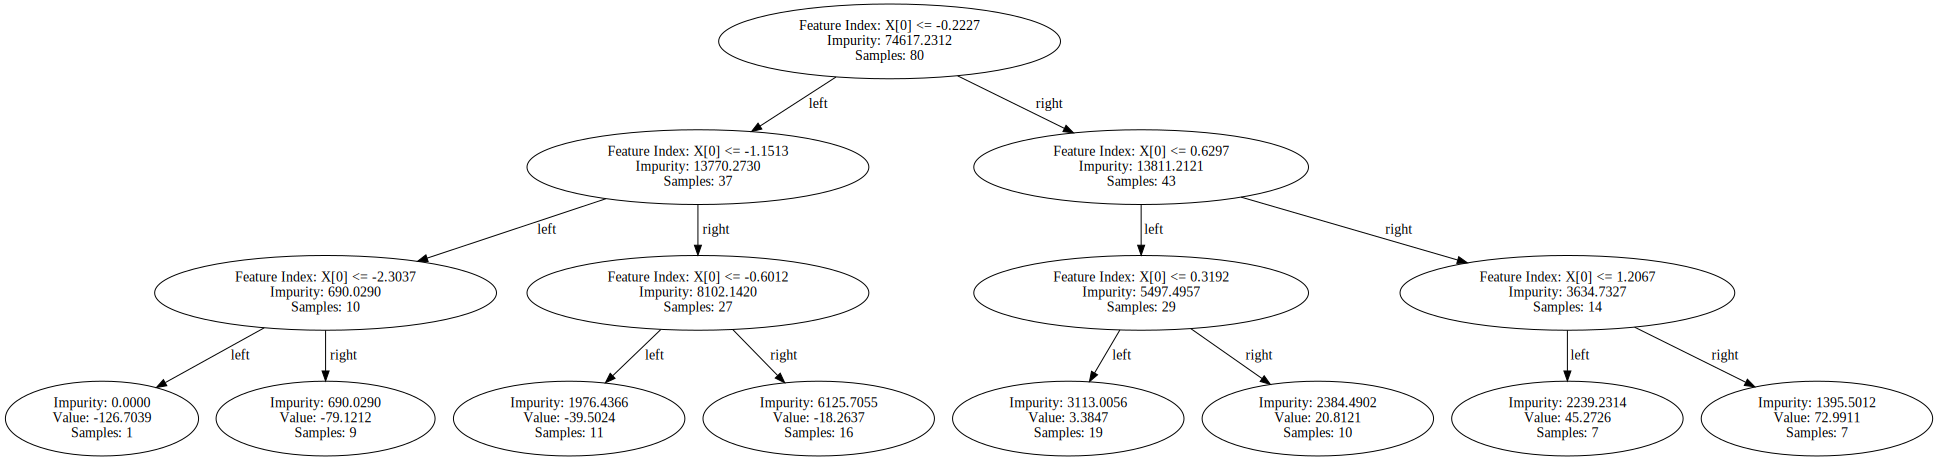

In [140]:
display(dot)

In [12]:
y_pred = reg_tree.predict(X_train)
print(f'MSE Train: {mean_squared_error(y_train, y_pred)}')
y_pred = reg_tree.predict(X_test)
mean_squared_error(y_test, y_pred)
print(f'MSE Test: {mean_squared_error(y_test, y_pred)}')

MSE Train: 224.05499298669446
MSE Test: 545.1856617326114


In [13]:
drt = DecisionTreeRegressor(max_depth=3)
drt.fit(X_train, y_train)
y_pred = drt.predict(X_train)
print(f'MSE Train: {mean_squared_error(y_train, y_pred)}')
y_pred = drt.predict(X_test)
print(f'MSE Test: {mean_squared_error(y_test, y_pred)}')

MSE Train: 224.05499298669446
MSE Test: 545.1856617326116


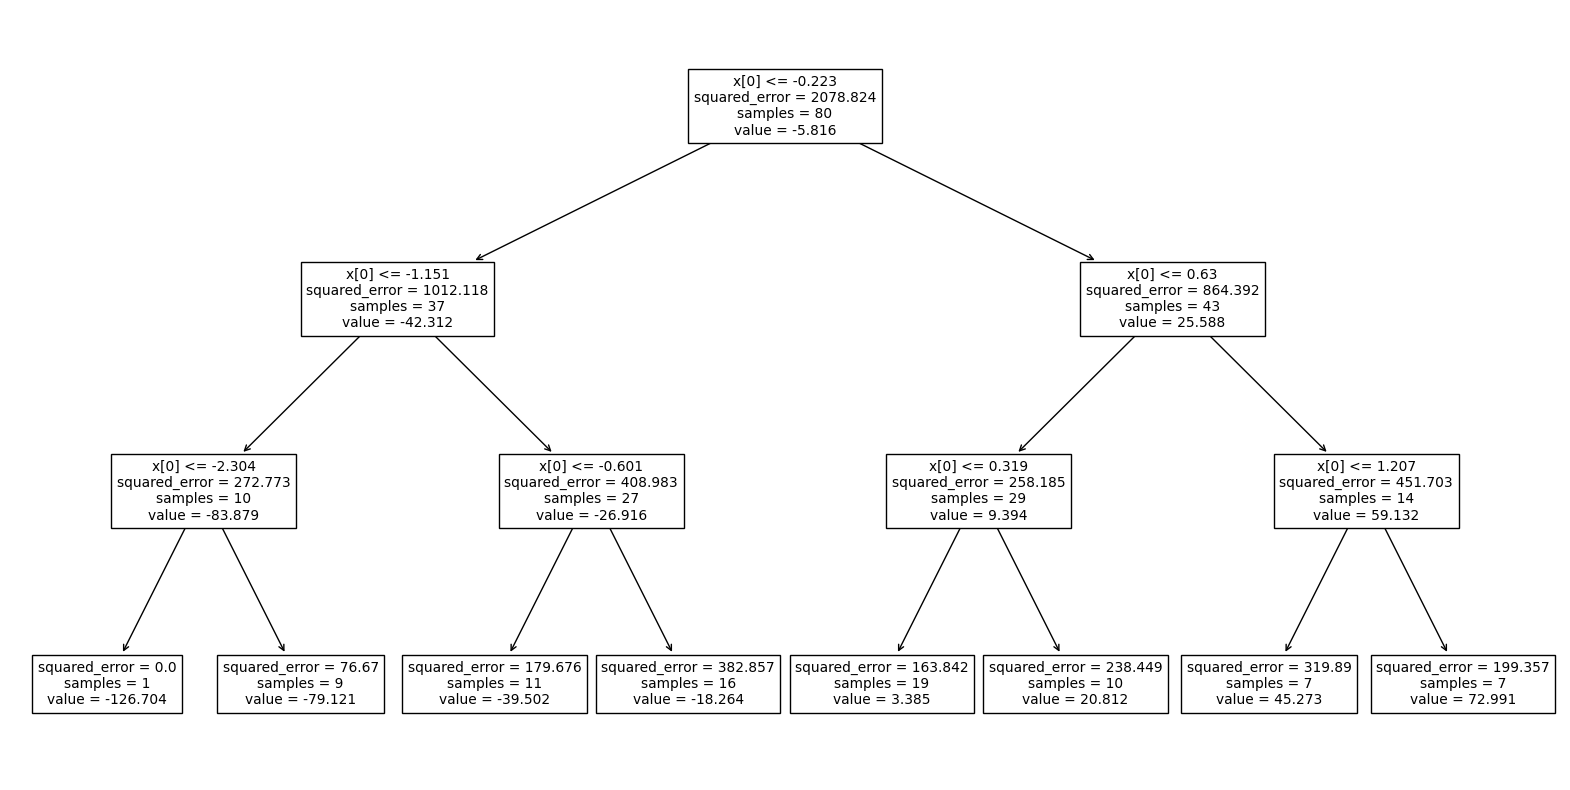

In [14]:
fig, ax = plt.subplots(figsize=(20, 10))
plot_tree(drt, ax=ax);

In [15]:
drt = DecisionTreeRegressor(min_samples_leaf=5)
drt.fit(X_train, y_train)
y_pred = drt.predict(X_train)
print(f'MSE Train: {mean_squared_error(y_train, y_pred)}')
y_pred = drt.predict(X_test)
print(f'MSE Test: {mean_squared_error(y_test, y_pred)}')

MSE Train: 196.88751514834297
MSE Test: 560.5999109371573


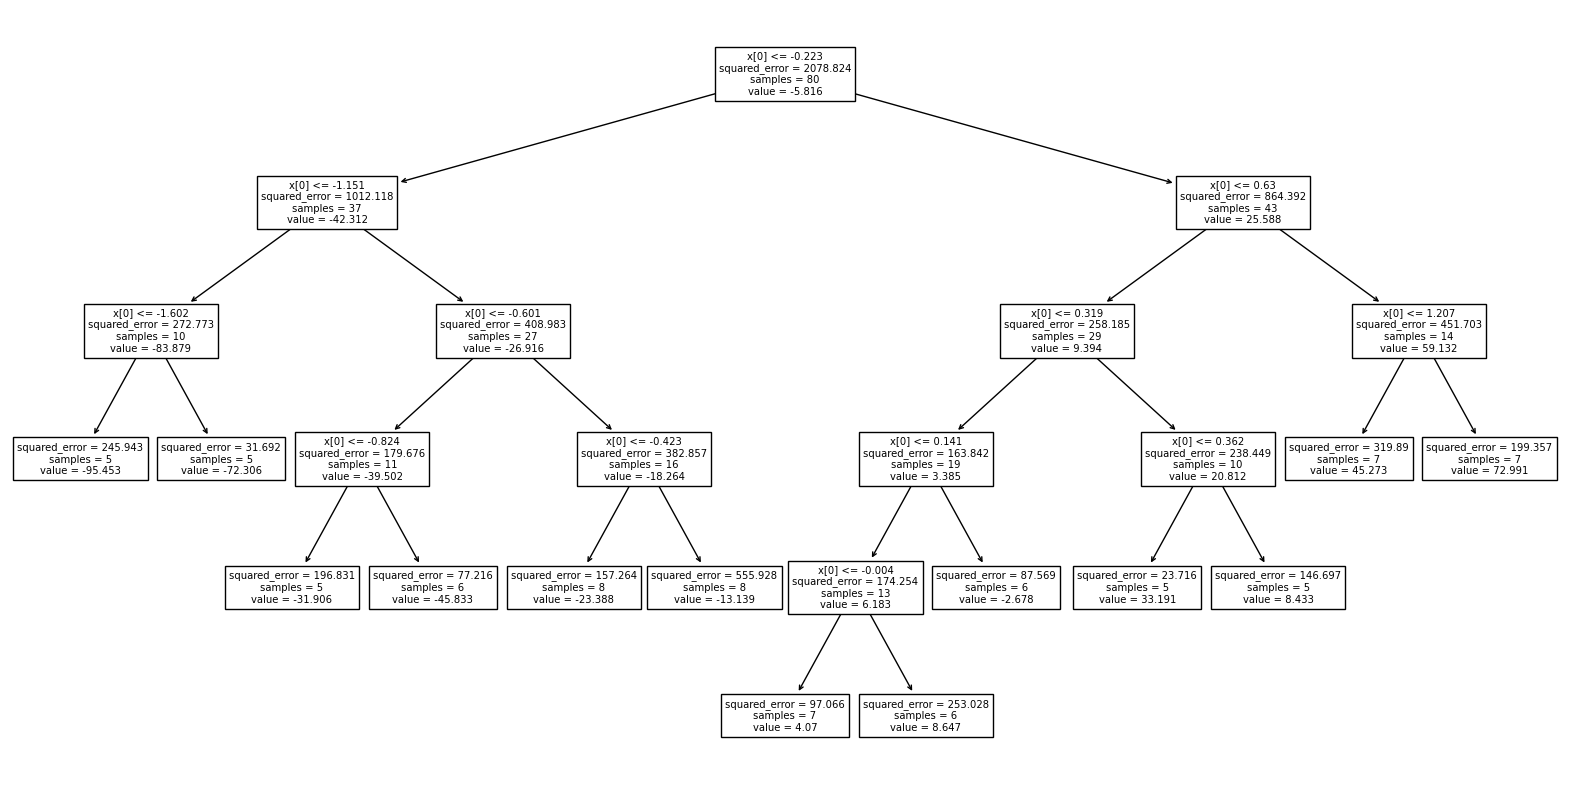

In [16]:
fig, ax = plt.subplots(figsize=(20, 10))
plot_tree(drt, ax=ax);

In [211]:
from ISLP import load_data

In [212]:
hitters = load_data('Hitters')

In [213]:
hitters = hitters[~hitters.Salary.isna()]

In [214]:
hitters['Salary_log'] = np.log(hitters.Salary)

In [215]:
X = hitters[['Years', 'RBI', 'PutOuts', 'Hits', 'Walks', 'Runs']]
y = hitters['Salary_log']

In [216]:
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, random_state=0, test_size=0.5)

In [217]:
unpruned_tree = RegressionTree(criterion='rss', ccp_alpha=0, min_samples_leaf=5)
unpruned_tree.fit(X_train, y_train)

In [218]:
y_hat = unpruned_tree.predict(X_test)

In [219]:
mean_squared_error(y_test, y_hat)

0.4904870434686838

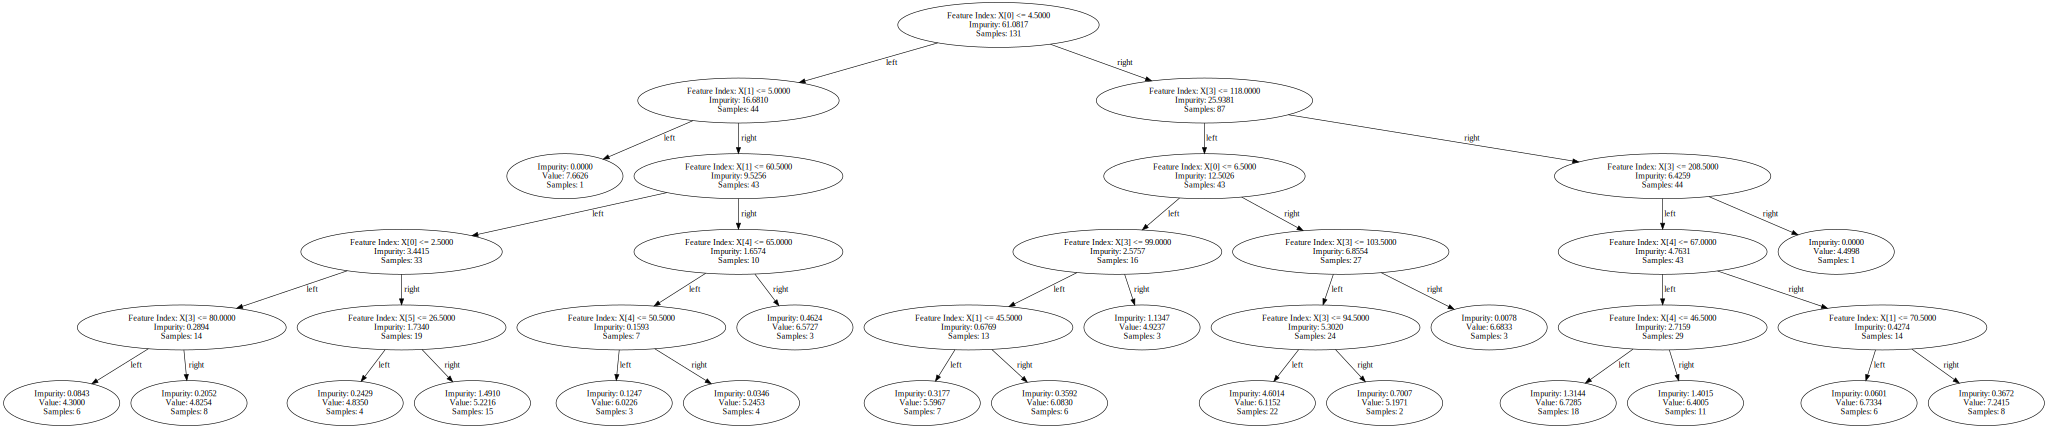

In [220]:
dot = graphviz.Digraph()
build_graph(unpruned_tree.tree, dot)
display(dot)

In [221]:
def cross_validation_alpha(X_train, y_train, alpha_values, n_splits):
    
    kfold = KFold(n_splits=n_splits)
    train_errors = {alpha: [] for alpha in alpha_values}
    test_errors = {alpha: [] for alpha in alpha_values}
    cv_errors = {alpha: [] for alpha in alpha_values}
    num_leaves = {alpha: [] for alpha in alpha_values}

    for alpha in alpha_values:
        for train_index, test_index in kfold.split(X_train):
            X_train_fold, y_train_fold = X_train[train_index], y_train[train_index]
            X_test_fold, y_test_fold = X_train[test_index], y_train[test_index]

            regression_tree = RegressionTree(criterion='rss', ccp_alpha=alpha, min_samples_leaf=5)
            regression_tree.fit(X_train_fold, y_train_fold)

            y_train_hat = regression_tree.predict(X_train_fold)
            train_mse = mean_squared_error(y_train_fold, y_train_hat)
            train_errors[alpha].append(train_mse)
            num_leaves[alpha].append(regression_tree.get_num_leaves())

            y_test_hat = regression_tree.predict(X_test_fold)
            test_mse = mean_squared_error(y_test_fold, y_test_hat)
            test_errors[alpha].append(test_mse)

            y_cv_hat = regression_tree.predict(X_test)
            cv_mse = mean_squared_error(y_test, y_cv_hat)
            cv_errors[alpha].append(cv_mse)
            
    def find_best_alpha(cv_errors):
        best_alpha = None
        best_avg_error = float('inf')
    
        for alpha, errors in cv_errors.items():
            avg_error = np.mean(errors)
            if avg_error < best_avg_error:
                best_avg_error = avg_error
                best_alpha = alpha
    
        return best_alpha

    best_alpha = find_best_alpha(cv_errors)
    return best_alpha, train_errors, test_errors, cv_errors, num_leaves

In [222]:
alpha_values = np.logspace(-5, 5, 10)
best_alpha, train_errors, test_errors, cv_errors, num_leaves = cross_validation_alpha(X_train, y_train, alpha_values, n_splits=6)

In [223]:
print(f'Best alpha {best_alpha}, train MSE: {np.mean(train_errors[best_alpha])}, test MSE: {np.mean(test_errors[best_alpha])}, CV MSE: {np.mean(cv_errors[best_alpha])}')

Best alpha 3.593813663804626, train MSE: 0.22788206847949524, test MSE: 0.45855732639535246, CV MSE: 0.4158265920891959


In [224]:
regression_tree = RegressionTree(criterion='rss', ccp_alpha=best_alpha, min_samples_leaf=5)
regression_tree.fit(X_train, y_train)

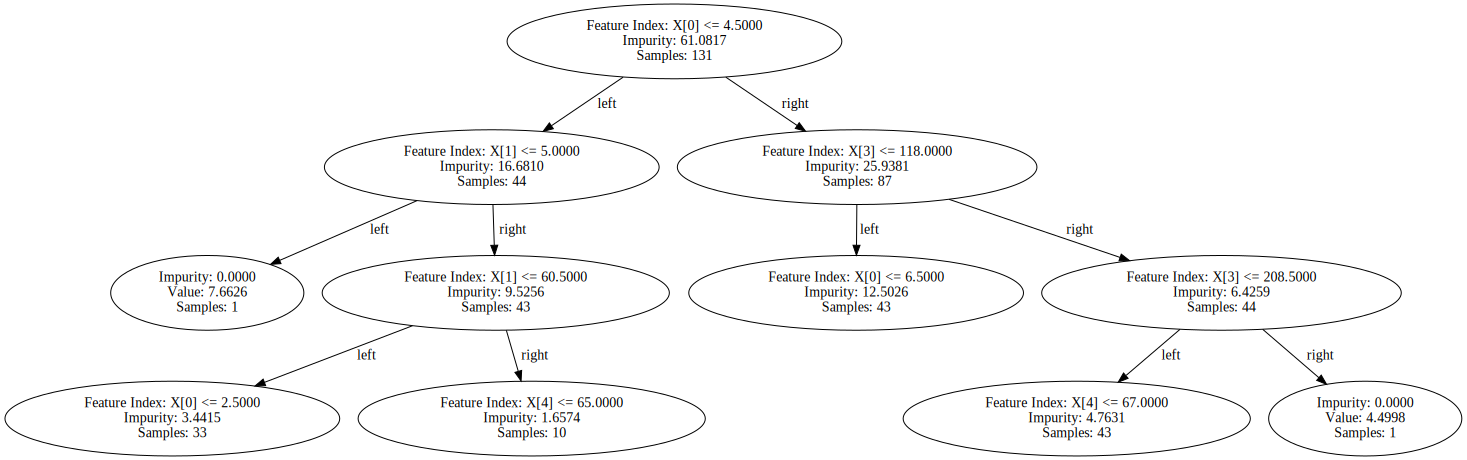

In [225]:
dot = graphviz.Digraph()
build_graph(regression_tree.tree, dot)
display(dot)